In [ ]:
import os
from io import open
import torch
import spacy
import re
nlp = spacy.load('en_core_web_sm')
from tqdm import tqdm
import torch.nn as nn


## Loading Files:
 We will first load our files, process its text and then separate statements and sentiments.

In [ ]:
def process_files(files):
  statements = []
  sentiments = []
  for filename in files:
    with open(filename,encoding='latin-1') as file:
      text = file.read()
      # Use regex to find currency and number patterns and add a space
      text = re.sub(r"(EUR|USD|GBP|euro|usd)\s*(\d+(\.\d+)?)", r"\1 \2", text) # Added 'euro'
      # Remove spaces within numbers (e.g., "20 .4" to "20.4")
      text = re.sub(r"(\d)\s+(\d|\.)", r"\1\2", text)
      text = re.sub(r"(\.)\s+(\d)", r"\1\2", text)
      text = re.sub( r",(?=\d)","",text)

      extracts = re.findall(r'(.*)@(\w+)',text) #all characters except new line before @ and word after @
      for statement,sentiment in extracts:
        s=''
        statement = nlp(statement)
        for token in statement:
          if token.pos_!='PUNCT':
            word = token.lemma_
            s+=word+' '
        statements.append(s)
        sentiments.append(sentiment)

  return statements,sentiments

In [ ]:
files = ['/content/drive/MyDrive/Sentences_AllAgree.txt','/content/drive/MyDrive/Sentences_75Agree.txt','/content/drive/MyDrive/Sentences_66Agree.txt','/content/drive/MyDrive/Sentences_50Agree.txt']
news_statements,news_sentiments = process_files(files)

In [ ]:
len(news_statements)


14780

## Making and Saving Vocabulary:

We need to extract unique words from all statements to make our vocabulary. I want to create tensors for each statement based on indexes of the words. However, there are numerical strings too and their importance must be retained for a stock setiment analysis model. This is why I will deal with them separately in my statement to tensor function.

In [ ]:
token_counter = {}
with tqdm(total=len(news_statements)) as progress_bar:
  for statement in news_statements:
    statement = nlp(statement)
    for token in statement:
      if token.is_alpha:
        token_text = token.text.lower()
        if token_text not in token_counter:
          token_counter[token_text] = 1
        else:
          token_counter[token_text]+=1
    progress_bar.update(1)

100%|██████████| 14780/14780 [02:27<00:00, 100.35it/s]


In [ ]:
len(list(token_counter.keys()))

7502

-> Our statement vector would begin with a start of string 'SOS' token and end with an end of string 'EOS' token. The '%' and 'us$' were not added in the counter due to .is_alpha attribute and hence we add them now.

-> We could store the numbers as is but they might clash with words at that index and hence they will be saved with an offset.

In [ ]:
unique_words = list(token_counter.keys())
USD = 'us$'
PERCENT_TOKEN = '%'
SOS_TOKEN = 'SOS_TOKEN'
EOS_TOKEN = 'EOS_TOKEN'
UNK_TOKEN = 'UNK_TOKEN'

word_to_index = {SOS_TOKEN:0.0, EOS_TOKEN:1.0, PERCENT_TOKEN:2.0,UNK_TOKEN:3,USD:4}
for i,word in enumerate(unique_words):
  word_to_index[word]  = float(i+5)

NUM_OFFSET = float(len(list(word_to_index.keys())) - 1.0)
NUM_OFFSET
vocab_size = len(list(word_to_index.keys())) + 2000

In [ ]:
import json

with open('/content/drive/MyDrive/word_to_index.json', 'w') as f:
    json.dump(word_to_index, f)

In [ ]:
import json

with open('/content/drive/MyDrive/word_to_index.json', 'r') as f:
    word_to_index = json.load(f)


print(len(list(word_to_index)))
NUM_OFFSET = float(len(list(word_to_index.keys())) - 1.0)
NUM_OFFSET

7507


7506.0

In [ ]:
NUM_OFFSET = float(len(list(word_to_index.keys())) - 1.0)
NUM_OFFSET
vocab_size = len(list(word_to_index.keys())) + 200
NUM_OFFSET

7506.0

## Converting statements and sentiments into tensors:
-> Many of the numbers are floating numbers in our data files and this is why I am creating tensors with dtype=float.32.

-> If an unknown word not present in the vocabulary is encounteres, it can be assigned the index for the UNK_TOKEN

In [ ]:
def is_float_convertible(s):
  try:
    float(s)
    return True
  except ValueError:
    return False

In [ ]:
def statement_to_tensor(statement):
  indexes = []
  statement = nlp(statement)
  for token in statement:
    if token.text.lower() in word_to_index:
      indexes.append(word_to_index[token.text.lower()])
    else:
      if token.like_num and not token.is_alpha:
        if is_float_convertible(token.text):
          indexes.append(NUM_OFFSET+float(token.text))


      else:
        indexes.append(word_to_index[UNK_TOKEN])

  tensor = torch.tensor(indexes,dtype=torch.float32)
  return tensor.view(-1,1)




In [ ]:
import torch
def sentiment_to_label(s):
  label = 0
  if s=='positive':
    label = 2
  elif s=='negative':
    label = 0
  else:
    label = 1
  return torch.tensor(label)


In [ ]:
sentiment_to_label('negative')

tensor(0)

In [ ]:
def vectorized_statements_sentiments(files):
  statements,sentiments = process_files(files)
  vectorized_statements = []
  labels = []
  for statement in statements:
    vectorized_statements.append(statement_to_tensor(statement))
  for sentiment in sentiments:
    labels.append(sentiment_to_label(sentiment))
  labels = torch.LongTensor(labels)
  return vectorized_statements,labels


In [ ]:
statement_vecs,  labels = vectorized_statements_sentiments(['/content/drive/MyDrive/Sentences_AllAgree.txt'])
labels[22]

tensor(2)

In [ ]:
statement_vecs[0]

tensor([[ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [ 6.],
        [13.],
        [14.],
        [15.],
        [ 6.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [ 8.],
        [ 9.],
        [19.],
        [21.]])

## Designing our neural network:

* Since I am using tensors with floating inputs, embedding cannot be used. This is why I will convert the statement tensors into dense matrices with nn.Linear.
* These will then be passed as x coordintes for the ReLU activation function.
* Then we pass this sequence through LSTM.
* Finally, we use the output from the last time step as input to a linear function with three output classes.

In [ ]:

input_size = 1
hidden_size = 128
num_layers = 1
output_size = 3




class Network(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(Network,self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.l1 = nn.Linear(input_size,10)
    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(10,hidden_size,num_layers = num_layers,bidirectional = True,batch_first=True)
    self.l2 = nn.Linear(2*hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self,input,h,c):
    input = self.relu(input)
    dense_input = self.l1(input)
    output,(h,c) = self.lstm(dense_input,(h,c))
    output = self.l2(output[:,-1,:])
    output = self.softmax(output)

    return output







In [ ]:
lstm = Network(input_size,hidden_size,output_size)


## Training:
 ->I will use Sentences_AllAgree.txt for initial model training to ensure your model learns from the most unambiguous, high-confidence examples.

 ->Gradually include datasets with lower agreement (75%, 66%, 50%) to increase the diversity and coverage of your training data.

->This exposes the model to more nuanced or ambiguous cases, which can improve its generalization to real-world data.


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class d(Dataset):
  def __init__(self,statement_vecs,labels):
    self.x = statement_vecs
    self.y = labels
    self.n_samples = len(statement_vecs)

  def __getitem__(self,index):
    return self.x[index],self.y[index]

  def __len__(self):
    return self.n_samples

In [ ]:
Allagree_ds = d(statement_vecs,labels)

In [ ]:
import torch.nn.utils.rnn as rnn_utils
import torch

def collate_fn(batch):
    # batch is a list of tuples: [(statement_vec, label), ...]
    statement_vecs, labels = zip(*batch)

    # Pad the statement vectors to the maximum length in the batch
    # We use the index of the UNK_TOKEN as the padding value
    padded_statement_vecs = rnn_utils.pad_sequence(statement_vecs, batch_first=True, padding_value=word_to_index[UNK_TOKEN])

    # Convert labels to a tensor
    labels = torch.stack(labels)

    return padded_statement_vecs, labels

In [ ]:
Allagree_dl = DataLoader(dataset = Allagree_ds, batch_size = 100, shuffle=True, collate_fn=collate_fn)

In [ ]:
i = 0
for batch in Allagree_dl:
  statement,label = batch
  print(statement.shape)
  print(label.shape)
  i+=1



torch.Size([100, 49, 1])
torch.Size([100])
torch.Size([100, 52, 1])
torch.Size([100])
torch.Size([100, 45, 1])
torch.Size([100])
torch.Size([100, 46, 1])
torch.Size([100])
torch.Size([100, 43, 1])
torch.Size([100])
torch.Size([100, 45, 1])
torch.Size([100])
torch.Size([100, 44, 1])
torch.Size([100])
torch.Size([100, 49, 1])
torch.Size([100])
torch.Size([100, 48, 1])
torch.Size([100])
torch.Size([100, 50, 1])
torch.Size([100])
torch.Size([100, 46, 1])
torch.Size([100])
torch.Size([100, 52, 1])
torch.Size([100])
torch.Size([100, 43, 1])
torch.Size([100])
torch.Size([100, 51, 1])
torch.Size([100])
torch.Size([100, 50, 1])
torch.Size([100])
torch.Size([100, 50, 1])
torch.Size([100])
torch.Size([100, 42, 1])
torch.Size([100])
torch.Size([100, 42, 1])
torch.Size([100])
torch.Size([100, 51, 1])
torch.Size([100])
torch.Size([100, 48, 1])
torch.Size([100])
torch.Size([100, 46, 1])
torch.Size([100])
torch.Size([100, 47, 1])
torch.Size([100])
torch.Size([64, 39, 1])
torch.Size([64])


In [ ]:
def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    criterion = nn.NLLLoss() # Using the same criterion as training

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for padded_statement_vecs, labels in dataloader:
            current_batch_size = padded_statement_vecs.size(0)

            # Initialize hidden state for the current batch size
            h_0 = torch.zeros(num_layers * 2, current_batch_size, hidden_size) # 2 for bidirectional
            c_0 = torch.zeros(num_layers * 2, current_batch_size, hidden_size) # 2 for bidirectional

            # Forward pass
            output = model(padded_statement_vecs, h_0, c_0)

            # Calculate loss
            loss = criterion(output, labels.squeeze())
            total_loss += loss.item() * current_batch_size # Accumulate loss weighted by batch size

            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            correct_predictions += (predicted == labels.squeeze()).sum().item()
            total_samples += current_batch_size

    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

In [ ]:
num_statements = len(statement_vecs)
criterion = nn.NLLLoss()
Allagree_losses = []
optimizer = torch.optim.Adam(lstm.parameters(),lr = 0.00001)
for epoch in range(100):
  epoch_loss = 0
  with tqdm(total = num_statements) as progress_bar:
    for padded_statement_vecs, labels in Allagree_dl:
      # Get the current batch size
      current_batch_size = padded_statement_vecs.size(0)

      # Initialize hidden state for the current batch size

      h_0 = torch.zeros(2, current_batch_size, hidden_size)
      c_0 = torch.zeros(2, current_batch_size, hidden_size)


      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass:

      output = lstm.forward(padded_statement_vecs, h_0, c_0)


      # Calculate the loss using the raw output and the label
      # Our output is (batch_size, output_size)
      # Our labels is (batch_size)
      loss = criterion(output, labels.squeeze()) # Squeeze labels to ensure correct shape for NLLLoss


      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()

      # Accumulate loss
      epoch_loss += loss.item()
      progress_bar.update(current_batch_size) # Update progress bar by batch size


  # Print average loss for the epoch
  avg_epoch_loss = epoch_loss / num_statements
  Allagree_losses.append(avg_epoch_loss)
  # Call evaluate and print the results
  if (epoch+1)%10==0:
    eval_loss, eval_accuracy = evaluate(lstm, Allagree_dl)
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

100%|██████████| 2264/2264 [00:06<00:00, 368.44it/s]


Epoch 10, Loss: 0.0090, Eval Loss: 0.8873, Eval Accuracy: 0.6232


100%|██████████| 2264/2264 [00:06<00:00, 363.13it/s]


Epoch 20, Loss: 0.0090, Eval Loss: 0.8797, Eval Accuracy: 0.6268


100%|██████████| 2264/2264 [00:06<00:00, 327.76it/s]


Epoch 30, Loss: 0.0086, Eval Loss: 0.8441, Eval Accuracy: 0.6387


100%|██████████| 2264/2264 [00:06<00:00, 361.27it/s]


Epoch 40, Loss: 0.0079, Eval Loss: 0.7748, Eval Accuracy: 0.7147


100%|██████████| 2264/2264 [00:06<00:00, 362.54it/s]


Epoch 50, Loss: 0.0077, Eval Loss: 0.7581, Eval Accuracy: 0.7111


100%|██████████| 2264/2264 [00:05<00:00, 395.75it/s]


Epoch 60, Loss: 0.0076, Eval Loss: 0.7460, Eval Accuracy: 0.7191


100%|██████████| 2264/2264 [00:06<00:00, 333.74it/s]


Epoch 70, Loss: 0.0075, Eval Loss: 0.7380, Eval Accuracy: 0.7231


100%|██████████| 2264/2264 [00:06<00:00, 376.09it/s]


Epoch 80, Loss: 0.0074, Eval Loss: 0.7283, Eval Accuracy: 0.7244


100%|██████████| 2264/2264 [00:06<00:00, 365.34it/s]


Epoch 90, Loss: 0.0074, Eval Loss: 0.7263, Eval Accuracy: 0.7208


100%|██████████| 2264/2264 [00:06<00:00, 335.34it/s]


Epoch 100, Loss: 0.0073, Eval Loss: 0.7134, Eval Accuracy: 0.7297


In [ ]:
Agree75_vecs,  Agree75_labels = vectorized_statements_sentiments(['/content/drive/MyDrive/Sentences_75Agree.txt'])
Agree66_vecs, Agree66_labels = vectorized_statements_sentiments(['/content/drive/MyDrive/Sentences_66Agree.txt'])

In [ ]:
Agree75_ds = d(Agree75_vecs,Agree75_labels)
Agree75_dl= DataLoader(dataset = Agree75_ds, batch_size = 100, shuffle=True, collate_fn=collate_fn)
Agree66_ds = d(Agree66_vecs,Agree66_labels)
Agree66_dl = DataLoader(dataset = Agree66_ds, batch_size = 100, shuffle=True, collate_fn=collate_fn)

In [ ]:
num_statements = len(Agree75_vecs)
criterion = nn.NLLLoss()
Agree75_losses = []
optimizer = torch.optim.Adam(lstm.parameters(),lr = 0.00001)
for epoch in range(100):
  epoch_loss = 0
  with tqdm(total = num_statements) as progress_bar:
    for padded_statement_vecs, labels in Agree75_dl:
      # Get the current batch size
      current_batch_size = padded_statement_vecs.size(0)

      # Initialize hidden state for the current batch size

      h_0 = torch.zeros(2, current_batch_size, hidden_size)
      c_0 = torch.zeros(2, current_batch_size, hidden_size)


      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass:

      output = lstm.forward(padded_statement_vecs, h_0, c_0)


      # Calculate the loss using the raw output and the label
      # Our output is (batch_size, output_size)
      # Our labels is (batch_size)
      loss = criterion(output, labels.squeeze()) # Squeeze labels to ensure correct shape for NLLLoss


      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()

      # Accumulate loss
      epoch_loss += loss.item()
      progress_bar.update(current_batch_size) # Update progress bar by batch size


  # Print average loss for the epoch
  avg_epoch_loss = epoch_loss / num_statements
  Agree75_losses.append(avg_epoch_loss)
  # Call evaluate and print the results
  if (epoch+1)%10==0:
    eval_loss, eval_accuracy = evaluate(lstm, Agree75_dl)
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

100%|██████████| 3453/3453 [00:09<00:00, 358.24it/s]


Epoch 10, Loss: 0.0076, Eval Loss: 0.7476, Eval Accuracy: 0.6953


100%|██████████| 3453/3453 [00:09<00:00, 354.92it/s]


Epoch 20, Loss: 0.0075, Eval Loss: 0.7457, Eval Accuracy: 0.7032


100%|██████████| 3453/3453 [00:09<00:00, 375.73it/s]


Epoch 30, Loss: 0.0075, Eval Loss: 0.7395, Eval Accuracy: 0.7003


100%|██████████| 3453/3453 [00:09<00:00, 378.04it/s]


Epoch 40, Loss: 0.0075, Eval Loss: 0.7373, Eval Accuracy: 0.7034


100%|██████████| 3453/3453 [00:10<00:00, 322.79it/s]


Epoch 50, Loss: 0.0075, Eval Loss: 0.7371, Eval Accuracy: 0.7006


100%|██████████| 3453/3453 [00:10<00:00, 333.69it/s]


Epoch 60, Loss: 0.0074, Eval Loss: 0.7352, Eval Accuracy: 0.7008


100%|██████████| 3453/3453 [00:09<00:00, 353.22it/s]


Epoch 70, Loss: 0.0075, Eval Loss: 0.7319, Eval Accuracy: 0.7037


100%|██████████| 3453/3453 [00:09<00:00, 355.01it/s]


Epoch 80, Loss: 0.0074, Eval Loss: 0.7348, Eval Accuracy: 0.7011


100%|██████████| 3453/3453 [00:09<00:00, 354.44it/s]


Epoch 90, Loss: 0.0074, Eval Loss: 0.7328, Eval Accuracy: 0.7032


100%|██████████| 3453/3453 [00:10<00:00, 340.77it/s]


Epoch 100, Loss: 0.0074, Eval Loss: 0.7310, Eval Accuracy: 0.7032


In [ ]:
num_statements = len(Agree66_vecs)
criterion = nn.NLLLoss()
Agree66_losses = []
optimizer = torch.optim.Adam(lstm.parameters(),lr = 0.00001)
for epoch in range(100):
  epoch_loss = 0
  with tqdm(total = num_statements) as progress_bar:
    for padded_statement_vecs, labels in Agree66_dl:
      # Get the current batch size
      current_batch_size = padded_statement_vecs.size(0)

      # Initialize hidden state for the current batch size

      h_0 = torch.zeros(2, current_batch_size, hidden_size)
      c_0 = torch.zeros(2, current_batch_size, hidden_size)


      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass:

      output = lstm.forward(padded_statement_vecs, h_0, c_0)


      # Calculate the loss using the raw output and the label
      # Our output is (batch_size, output_size)
      # Our labels is (batch_size)
      loss = criterion(output, labels.squeeze()) # Squeeze labels to ensure correct shape for NLLLoss


      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()

      # Accumulate loss
      epoch_loss += loss.item()
      progress_bar.update(current_batch_size) # Update progress bar by batch size


  # Print average loss for the epoch
  avg_epoch_loss = epoch_loss / num_statements
  Agree66_losses.append(avg_epoch_loss)
  # Call evaluate and print the results
  if (epoch+1)%10==0:
    eval_loss, eval_accuracy = evaluate(lstm, Agree66_dl)
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

100%|██████████| 4217/4217 [00:13<00:00, 310.21it/s]


Epoch 10, Loss: 0.0082, Eval Loss: 0.7965, Eval Accuracy: 0.6661


100%|██████████| 4217/4217 [00:12<00:00, 345.50it/s]


Epoch 20, Loss: 0.0082, Eval Loss: 0.7971, Eval Accuracy: 0.6661


100%|██████████| 4217/4217 [00:12<00:00, 332.53it/s]


Epoch 30, Loss: 0.0082, Eval Loss: 0.7976, Eval Accuracy: 0.6668


100%|██████████| 4217/4217 [00:13<00:00, 306.46it/s]


Epoch 40, Loss: 0.0081, Eval Loss: 0.7970, Eval Accuracy: 0.6678


100%|██████████| 4217/4217 [00:13<00:00, 316.40it/s]


Epoch 50, Loss: 0.0081, Eval Loss: 0.7990, Eval Accuracy: 0.6685


100%|██████████| 4217/4217 [00:11<00:00, 352.67it/s]


Epoch 60, Loss: 0.0081, Eval Loss: 0.7957, Eval Accuracy: 0.6678


100%|██████████| 4217/4217 [00:11<00:00, 351.86it/s]


Epoch 70, Loss: 0.0081, Eval Loss: 0.7928, Eval Accuracy: 0.6697


100%|██████████| 4217/4217 [00:11<00:00, 363.61it/s]


Epoch 80, Loss: 0.0081, Eval Loss: 0.7939, Eval Accuracy: 0.6697


100%|██████████| 4217/4217 [00:12<00:00, 346.20it/s]


Epoch 90, Loss: 0.0081, Eval Loss: 0.7910, Eval Accuracy: 0.6685


100%|██████████| 4217/4217 [00:12<00:00, 350.68it/s]


Epoch 100, Loss: 0.0081, Eval Loss: 0.7912, Eval Accuracy: 0.6706


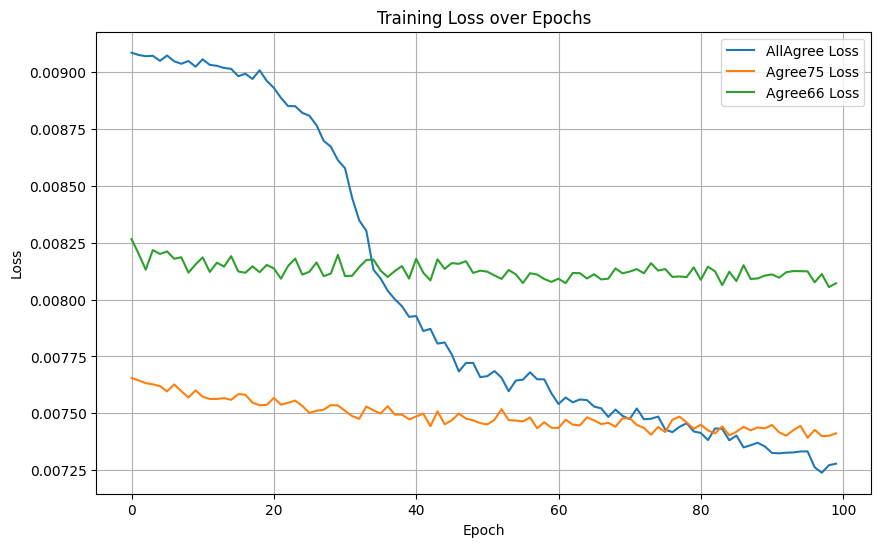

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Allagree_losses, label='AllAgree Loss')
plt.plot(Agree75_losses, label='Agree75 Loss')
plt.plot(Agree66_losses, label='Agree66 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def process_filesn(files):
  statements = []
  sentiments = []
  for filename in files:
    with open(filename,encoding='utf-8') as file:
      text = file.read()
      text = re.sub( r",(?=\d)","",text)

      extracts = re.findall(r'(.*)@(.*)',text) #all characters except new line before @ and rate change after @
      for statement,sentiment in extracts:
        s=''
        statement = nlp(statement)
        for token in statement:
          if token.pos_!='PUNCT':
            word = token.lemma_
            s+=word+' '
        statements.append(s)
        sentiments.append(sentiment)

  return statements,sentiments

In [ ]:
sample_statements,price_change = process_filesn(['/content/drive/MyDrive/newsVSchange.txt'])
print(sample_statements)
print(price_change)

['Tesla share fall nearly 8 % after Elon Musk launch America Party ', 'Tesla stock soar after Elon Musk regret clash with Donald Trump ', 'announce 9 % yoy decline in total May sale passenger vehicle down 11 % ', 'announce ₹ 15000 crore capex plan for FY26 Q4 net profit more than double ', 'report 25 % yoy rise in Q4 profit record annual revenue and strong renewable growth ', 'inaugurated Phase II expansion of Kalinganagar plant boost capacity ', 'Q1 FY26 sale report 210415 unit 10 % yoy decline ', '118th Annual General Meeting share rally on positive steel outlook ', 'Tribunal order $ 490 m damage record solar project commission ', 'minor share price drop amid broad market analysis ', 'JLR Q1 FY26 wholesale down 10.7 % global wholesale down 9 % rebound as JLR business update release ', 'steady crude steel output deliverie down 3.8 % due to shutdown ']
['-8', '+10', '-2.98', '+4.4', '+3.0', '+2.5', '-0.61', '+0.27', '-0.20', '+0.63', '-0.06', '+0.04']


In [ ]:
def vectorized_statements(files):
  statements,price_change = process_filesn(files)
  vectorized_statements = []
  for statement in statements:
    vectorized_statements.append(statement_to_tensor(statement))
  for i in range(len(price_change)):
    price_change[i] = float(price_change[i])

  return vectorized_statements,price_change


In [ ]:
s_vectors,price_change = vectorized_statements(['/content/drive/MyDrive/newsVSchange.txt'])

In [ ]:
n_samples = len(s_vectors)
price_change
s_vectors[0]

tensor([[7.0800e+02],
        [7.7000e+01],
        [1.2540e+03],
        [3.0000e+00],
        [8.0060e+03],
        [2.3460e+03],
        [3.0000e+00],
        [7.5100e+03],
        [3.7510e+03],
        [1.1200e+02],
        [1.8370e+03]])

In [ ]:
batch_size = n_samples
hidden_0 = torch.zeros(2,1,hidden_size)
cellstate_0 = torch.zeros(2,1,hidden_size)


In [ ]:
model_outputs = []
for i in range(n_samples):
  output_ = lstm.forward(s_vectors[i].unsqueeze(0),hidden_0,cellstate_0)
  _,idx = torch.max(output_,dim=-1)
  if idx.item()==0:
    model_outputs.append('negative')
  elif idx.item()==2:
    model_outputs.append('positive')
  else:
    model_outputs.append('neutral')

In [ ]:
model_outputs

['neutral',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive']

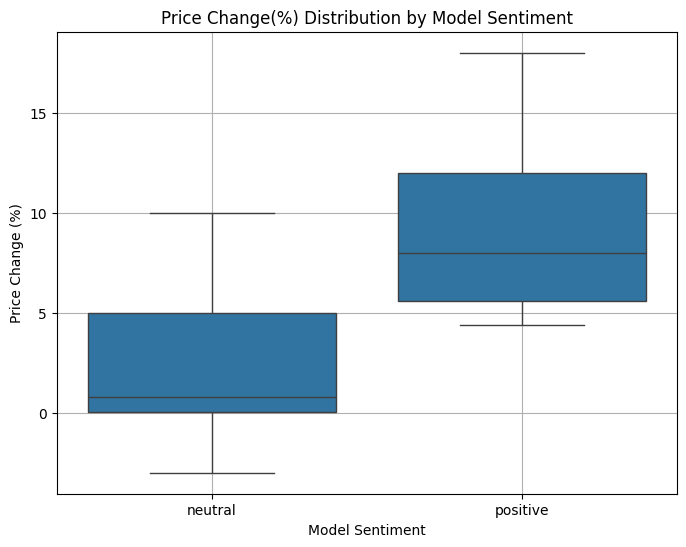

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Model Output': model_outputs, 'Price Change': price_change})

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Model Output', y='Price Change', data=plot_df)
plt.title('Price Change(%) Distribution by Model Sentiment')
plt.xlabel('Model Sentiment')
plt.ylabel('Price Change (%)')
plt.grid(True)
plt.show()